# First Year Project - Project 1 - Corona and Weather

----
**Group 6 (F)**: Bjørn Søvad (bjso@itu.dk), Katarina Kraljevic (katkr@itu.dk), Mirka Katuscáková (katu@itu.dk), Emma Cecilie Bjerring Jensen (emcj@itu.dk), Viggo Yann Unmack Gascou (viga@itu.dk)

----

### Instructions for running this Jupyter Notebook
Make sure to run this notebook in trusted mode. \
This will ensure that the code blocks run correctly and display the output correctly

### Required Libraries
If needed you can read more documentation about the different libraries that are imported
* [Pandas Documentation](https://pandas.pydata.org/docs/)
* [Numpy Documentation](https://numpy.org/doc/)
* [Folium Documentation](https://python-visualization.github.io/folium/)
* [Json Documentation](https://docs.python.org/3/library/json.html)
* [Statsmodels Documentation](https://www.statsmodels.org/stable/)
* [Scipy Documentation](https://scipy.github.io/devdocs/index.html)
* [Matplotlib Documentation](http://matplotlib.org/)
* [Seaborn Documentation](http://seaborn.pydata.org/)

In [1]:
#Importing needed libraries
import pandas as pd                                                            # used to provide major datastructure pd.DataFrame() to store the datasets
import numpy as np                                                             # used for numerical calculations and fast array manipulations
import folium                                                                  # used for spatial data visualizations
import json                                                                    # used for loading json data correctly
import statsmodels.api as sm                                                   # used to run multivariate linear regression
from scipy.stats import pearsonr, spearmanr                                    # used to run 'pearson' and 'spearman' association tests of numerical variables on two variables
from statsmodels.stats.multitest import multipletests                          # used to run multiple tests of p-values for multiple variables
import matplotlib.pyplot as plt                                                # used for plotting and visualizing our data
import matplotlib.dates as mdates                                              # used to create right ticks for x-axes in diagrams
import seaborn as sns                                                          # used for plotting and visualizing our data
from IPython.display import Markdown, display                                  # used to print stuff with markdown/HTML formatting for bold text and colored text
def printmd(string):
    display(Markdown(string))

### Loading the raw data

In [2]:
#Importing the raw corona data from Germany
corona_df = pd.read_csv('../data/raw/corona/de_corona.csv', sep = '\t')
corona_df.name = 'corona_df'

#Importing the raw weather data for the countries, Germany, Netherlands, Sweden and Denmark
weather_df = pd.read_csv("../data/raw/weather/weather.csv")
weather_df.name = 'weather_df'

#Loading in the metadata json using the Python json library
with open('../data/raw/metadata/de_metadata.json','r', encoding="utf8") as f:
    country_metadata=json.load(f)

#Creating a folium map (called de_map) that is based around Germany and uneditable in terms of placement and zoom
de_map = folium.Map(location = [51.1657, 10.4515], zoom_start = 6, crs = 'EPSG3857', 
    zoom_control = False, scrollWheelZoom = False, dragging = False)

#Loading in the geojson that contains data for the regions and borders of Germany and adding it to the folium map
folium.GeoJson('../data/raw/shapefiles/de.geojson', name = "geojson").add_to(de_map)
folium.LayerControl().add_to(de_map);

### Task 0: Data filtering and cleaning

The data analysis done in this notebook is done with a handful of different datasets:

> CSV: Corona (DE) - Contains the Number of new infections (per day) and Number of new casualties (per day) filtered by day and region in Germany for each day in the period `2020-01-02` to `2021-02-21`.
>
> CSV: Weather - Contains information about several indicators of weather conditions for each region in Germany, Denmark, Sweden and Netherlands for each day in the period `2020-02-13` to `2021-02-21`
>
> JSON: Metadata (DE) - Contains more information on the population in the different regions in Germany
>
> GEOJSON: Geojson (DE) - Holds the geojson data for the different regions in Germany

### Initial inspection of the datasets

In [3]:
row, cols = weather_df.shape
print("Number of Rows: " + str(row))
print("Number of Columns: " + str(cols))
weather_df.head()

Number of Rows: 20220
Number of Columns: 9


,date,iso3166-2,RelativeHumiditySurface,SolarRadiation,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed
0,2020-02-13,DE-BB,76.337444,1.824290e+06,2.403341e+06,276.551573,0.003355,2.777806,4.542822
1,2020-02-13,DE-BE,76.065297,1.786373e+06,2.408182e+06,276.844633,0.003523,4.671329,4.761509
2,2020-02-13,DE-BW,80.113988,1.505760e+06,2.290158e+06,276.227143,0.008013,4.268546,4.467024
3,2020-02-13,DE-BY,81.554346,2.363013e+06,2.275361e+06,275.583053,0.005227,4.417797,3.677414
4,2020-02-13,DE-HB,87.167414,8.389756e+03,2.406940e+06,276.237452,0.007715,1.794872,4.699573


We can see that the `weather` dataset contains `9` different variables for the countries Germany, Denmark Sweden and Netherlands spread across `20220` rows and `9` columns. Each row contains `7` different weather measurements for a particular day in a specific country and region:
> `Date` (YYYY-DD-MM): Is the day of which the weather measurements were made and reported
>
> `Iso3166-2`: Is the [ISO 3166-2](https://en.wikipedia.org/wiki/ISO_3166-2) code for the region for which the weather measurements were made
>
> `Relative Humidity Surface` (%): Is the **daily average** relative humidity of the surface
>
> `Solar Radiation`(W/m^2): Is the **daily sum** of the solar radiation from the sun
>
> `Surface Pressure` (Pa): Is the **daily sum** of the atmospheric pressure at the surface of the earth
>
> `TemperatureAboveGround` (º K): Is the **daily average** of the temperature above ground
>
> `Total Precipitation` (mm): Is the **daily sum** of the total precipitation 
>
> `UV Index` (Numerical value): Is the **daily sum** of the strength of the ultraviolet radiation
>
> `Wind Speed`(m/s): Is the **daily average** of the wind speed

In [4]:
row, cols = corona_df.shape
print("Number of Rows: " + str(row))
print("Number of Columns: " + str(cols))
corona_df.head()

Number of Rows: 5602
Number of Columns: 4


,date,region_code,confirmed_addition,deceased_addition
0,2020-01-02,Nordrhein-Westfalen,1,0
1,2020-01-07,Nordrhein-Westfalen,1,0
2,2020-01-09,Nordrhein-Westfalen,1,1
3,2020-01-12,Nordrhein-Westfalen,1,0
4,2020-01-14,Nordrhein-Westfalen,1,0


We can see that the `corona` dataset contains `4` different variables for corona reports for Germany spread across `5602` rows and `4` columns. Each row contains `2` different corona reports for a particular day in a specific country and region:
> `Date` (YYYY-DD-MM): Is the day of which the corona report was made
>
> `Region Code`: Is the region code for the region for which the corona report was made
>
> `Confirmed Addition`: Is the number of new confirmed infections of corona for the specific day in the specified region
>
> `Deceased Addition`: Is the number of newly confirmed deaths for the specific day in the specified region

### Sanity check
Checking to see if there are any missing (Na or NaN) values in either of the two datasets \
\
We also check if there are any duplicate rows in either of the two datasets. \
\
Next we also check if any of the reported numerical values are negative. It would not make sense to e.g., have a negative UV Index or a negative comfirmed COVID-19 cases.

### Checking for NaN values:

In [5]:
datasets = [weather_df, corona_df]
for dataset in datasets:
    if dataset.name == "weather_df":
        printmd("### **Weather Dataset**")
    else: 
        printmd("### **Corona Dataset**")

    print(dataset.isnull().any())
    print("-----------------------------------------------")
    printmd( "##### <span style='color:red'> ❌ **Oh No! There are missing data values in the dataset!**</span>" if dataset.isnull().any().any() 
            else
            "##### <span style='color:lightgreen'> ✅ **Great! There are no missing data values in the dataset!**</span>")
    printmd("____")

### **Weather Dataset**

date                       False
iso3166-2                  False
RelativeHumiditySurface    False
SolarRadiation             False
Surfacepressure            False
TemperatureAboveGround     False
Totalprecipitation         False
UVIndex                    False
WindSpeed                  False
dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no missing data values in the dataset!**</span>

____

### **Corona Dataset**

date                  False
region_code           False
confirmed_addition    False
deceased_addition     False
dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no missing data values in the dataset!**</span>

____

### Checking for duplicates:

In [6]:
for dataset in datasets:
    if dataset.name == "weather_df":
        printmd("### **Weather Dataset**")
    else: 
        printmd("### **Corona Dataset**")

    print(dataset.duplicated())
    print("-----------------------------------------------")
    printmd( "##### <span style='color:red'> ❌ **Oh No! There are duplicate data values in the dataset!**</span>" if dataset.duplicated().any()
            else
            "##### <span style='color:lightgreen'> ✅ **Great! There are no duplicate data values in the dataset!**</span>")
    printmd("____")

### **Weather Dataset**

0        False
1        False
2        False
3        False
4        False
         ...  
20215    False
20216    False
20217    False
20218    False
20219    False
Length: 20220, dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no duplicate data values in the dataset!**</span>

____

### **Corona Dataset**

0       False
1       False
2       False
3       False
4       False
        ...  
5597    False
5598    False
5599    False
5600    False
5601    False
Length: 5602, dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no duplicate data values in the dataset!**</span>

____

### Checking for values negative reports

In [7]:
for dataset in datasets:
    if dataset.name == "weather_df":
        printmd("### **Weather Dataset**")
    else: 
        printmd("### **Corona Dataset**")
    dataset = dataset.select_dtypes(include=np.number)

    print((dataset < 0).any())
    print("-----------------------------------------------")
    printmd( "##### <span style='color:red'> ❌ **Oh No! There are data values that shouldn't be negative in the dataset!**</span>" if (dataset < 0).any().any() 
            else
            "##### <span style='color:lightgreen'> ✅ **Great! There are no data values that shouldn't be negative in the dataset!**</span>")
    printmd("____")

### **Weather Dataset**

RelativeHumiditySurface    False
SolarRadiation             False
Surfacepressure            False
TemperatureAboveGround     False
Totalprecipitation         False
UVIndex                    False
WindSpeed                  False
dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no data values that shouldn't be negative in the dataset!**</span>

____

### **Corona Dataset**

confirmed_addition    False
deceased_addition     False
dtype: bool
-----------------------------------------------


##### <span style='color:lightgreen'> ✅ **Great! There are no data values that shouldn't be negative in the dataset!**</span>

____

### Fixing variable names

We noticed that the variables in the weather dataset had a different naming scheme than the corona dataset so in order to make it more seamless we rename the variables to all have the same naming scheme.

In [4]:
weather_df.rename(columns={
    'date': 'date', 
    'iso3166-2': 'region_code',
    'RelativeHumiditySurface': 'relative_humidity_surface', 
    'SolarRadiation': 'solar_radiation', 
    'Surfacepressure': 'surface_pressure', 
    'TemperatureAboveGround': 'temperature_above_ground', 
    'Totalprecipitation': 'total_precipitation', 
    'UVIndex': 'UV_index', 
    'WindSpeed': 'wind_speed'}, inplace=True)

Since there are no missing or falsely reported data values we can move on to cleaning and filtering the data.

#### _Let's start by cleaning and filtering the corona data for Germany:_

We first start of by creating to dictionaries that are going to help us to map both regions and their populations to the dataframes:

In [5]:
#Creating a dictionary that contains the full names of the different regions as keys and their respective iso3166-2 code as values
region_map = {country_metadata["country_metadata"][i]["covid_region_code"]: 
    country_metadata["country_metadata"][i]["iso3166-2_code"] for i in range(len(country_metadata["country_metadata"]))}

#Creating a dictionary that contains the full names of the different regions as keys and their respective populations as values
population_map = {country_metadata["country_metadata"][i]["iso3166-2_code"]: 
    country_metadata["country_metadata"][i]["population"] for i in range(len(country_metadata["country_metadata"]))}

Now with the region_map we can create extra columns to add the iso3166-2 code to the corona dataframe as it only contained to full region codes. \
\
We can also use the population_map to add a column with the population of each of the regions to the corona dataframe. \
\
With the population column we can create a column that contains the cases and deaths per capita using the confirmed addition and the population column we just created.

In [6]:
#Using the region_map dictionary to create a new column with the respective iso3166-2 code for each region based on the full region name
#from the region_code column
corona_df["region_code"] = corona_df["region_code"].map(region_map)

#Using the population_map dictionary to create a new column with the respective population for each region based on the iso3166-2 code
#from the iso3166-2 column
corona_df["population"] = corona_df["region_code"].map(population_map)

#Also adding a cases and deaths per capita column that is created using the confirmed covid cases and deaths respectively divided by the population in that region
corona_df["cases_pc"] = corona_df["confirmed_addition"] / corona_df["population"]
corona_df["deaths_pc"] = corona_df["deceased_addition"] / corona_df["population"]

#### _Now moving on to the weather dataset:_

We start off by first filtering out all the other countries from the dataset as we are not interested in their data.\
\
We can then convert the temperature measurements from º K to º C, we do that by subtracting `273.15` from each row value in the temperature measurements

<span style='color:IndianRed'>Please note! Be careful to not run the following cell more than once as this will keep doing the subtractions which could lead to negative and or NaN temperature values</span>

In [7]:
#Filtering out all the weather data that is not relevant as we are only interested in weatherdata from Germany
weather_df = weather_df[weather_df["region_code"].str.startswith("DE")]

#Converting the temperature from Kelvin to Celsius
weather_df["temperature_above_ground"] = weather_df["temperature_above_ground"] - 273.15

Finally we can merge the corona_df and the weather_df to create on big dataframe/dataset that contains all the data that we need.

In [8]:
#Merging the weatherdata with the coronadata to create one dataframe with all the data that we need
merged_df = corona_df.merge(weather_df, on = ["date", "region_code"])
merged_df

,date,region_code,confirmed_addition,deceased_addition,population,cases_pc,deaths_pc,relative_humidity_surface,solar_radiation,surface_pressure,temperature_above_ground,total_precipitation,UV_index,wind_speed
0,2020-02-16,DE-MV,1,0,1609675,6.212434e-07,0.0,69.818665,4.562424e+04,2.392858e+06,11.144049,0.004641,0.211216,7.888859
1,2020-02-17,DE-BB,1,0,2511917,3.981023e-07,0.0,64.189273,9.007504e+05,2.409194e+06,9.162595,0.001005,2.631685,6.319781
2,2020-02-18,DE-BB,1,0,2511917,3.981023e-07,0.0,71.904630,4.042940e+06,2.421421e+06,6.529468,0.002388,4.037911,6.150824
3,2020-02-20,DE-NW,1,0,17932651,5.576420e-08,0.0,81.738535,1.064802e+06,2.383996e+06,6.513867,0.006802,3.524003,6.477330
4,2020-02-24,DE-BW,1,0,11069533,9.033805e-08,0.0,80.314208,6.604918e+05,2.308155e+06,8.744530,0.005284,5.613589,4.663207
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5575,2021-02-21,DE-RP,120,0,4084844,2.937689e-05,0.0,65.642820,8.457394e+06,2.348996e+06,8.973657,0.000000,7.879810,3.009041
5576,2021-02-21,DE-SN,68,0,4077937,1.667510e-05,0.0,74.638170,6.687276e+06,2.363996e+06,6.127820,0.000008,5.409593,4.648033
5577,2021-02-21,DE-ST,84,0,2208321,3.803795e-05,0.0,69.587170,7.276057e+06,2.408002e+06,9.268775,0.000000,5.273630,2.972845
5578,2021-02-21,DE-SH,113,0,2896712,3.900975e-05,0.0,78.077610,5.698494e+06,2.431487e+06,8.793486,0.000000,4.474084,2.532838


Now that we have merged the two datasets we want to check how many rows we lost from each of the two datasets. \
\
We do that by subtracting the number of rows from each of the two datasets by the number of rows in the merged dataset.

In [13]:
weather_lost = weather_df.shape[0]-merged_df.shape[0]
corona_lost = corona_df.shape[0]-merged_df.shape[0]
print(f"We lost {weather_lost} rows from the weather dataset.")
print(f"We lost {corona_lost} rows from the corona datset")
print(f"We lost {weather_lost+corona_lost} rows in total")

We lost 420 rows from the weather dataset.
We lost 22 rows from the corona datset
We lost 442 rows in total


As we can see we lost 442 rows from the two datasets by merging.
This could be due to the fact that the corona dataset starts from the 2nd of January \
whereas the weather dataset starts on the 13th of February and therefore some of the corona data is lost. \
It could also be possible that on the days that do match one of the datasets does not contain data on the same region as the other dataset, resulting in more dropped rows.


### Outputting and re-loading filtered and cleaned data

Now having cleaned and filtered to two datasets we can create new `.csv` files that we can use for the rest of this notebook. \
\
We do this by using the built-in pandas function `pd.to_csv` that will automatically convert the pandas dataframe to a `.csv` file \
\
We will also create shortcuts to those files so the code becomes more human readable.

In [9]:
# The pd.to_csv function is run by first specifying the file path and name that it should create.
# The index = False argument specifies to the function that the .csv file should not include the index that the pandas dataframe has
corona_df.to_csv("../Data/processed/de_corona.csv", index = False)
weather_df.to_csv("../Data/processed/de_weather.csv", index = False)
merged_df.to_csv("../Data/processed/de_corona_weather.csv", index = False)

# Now creating the shortcuts to the processed datasets
corona_path = "../Data/processed/de_corona.csv"
weather_path = "../Data/processed/de_weather.csv"
merged_path = "../Data/processed/de_corona_weather.csv"

We can now read in and overwrite the name variables of the datasets to make sure that the data we use has been filtered and cleaned correctly:

In [10]:
corona_df = pd.read_csv(corona_path)
weather_df = pd.read_csv(weather_path)
merged_df = pd.read_csv(merged_path)

### Task 1: Single variable analysis

#### Creating dataframes for plotting

##### Creating dataframes with different time frequency

In [16]:
#changing values in date column to be datetime type
merged_df["date"] = pd.to_datetime(merged_df["date"])

#creating dataframes with dates and summed confirmed addition
#all the dates
merged_dfbydate=merged_df.groupby(by='date')['confirmed_addition'].sum().reset_index()
#one date per week
merged_dfbyweek=merged_dfbydate.groupby(pd.Grouper(key='date',freq='W')).sum().reset_index()
#one date per month
merged_dfbymonth=merged_dfbydate.groupby(pd.Grouper(key='date',freq='M')).sum().reset_index()


##### Creating dataframes with weather data for different time frequency

In [17]:
#now we create dataframes with weather data but only for some dates we will calculate the mean of the variable for that date
#daily
temp_dfbydate=merged_df.groupby(by='date').mean()
temp_dfbydate=temp_dfbydate.loc[:,temp_dfbydate.columns!='confirmed_addition']
merged_dfbydate=merged_dfbydate.merge(temp_dfbydate,on='date')
#weekly
temp_dfbyweek=merged_df.groupby(by='date').mean()
temp_dfbyweek=temp_dfbyweek.loc[:,temp_dfbyweek.columns!='confirmed_addition']
merged_dfbyweek=merged_dfbyweek.merge(temp_dfbyweek,on='date')
#monthly
temp_dfbymonth=merged_df.groupby(by='date').mean()
temp_dfbymonth=temp_dfbymonth.loc[:,temp_dfbymonth.columns!='confirmed_addition']
merged_dfbymonth=merged_dfbymonth.merge(temp_dfbymonth,on='date')

##### Creating dataframes with COVID-19 data for different time frequency

In [18]:
#creating dataframes with only date, region_code and confirmed addition columns grouped by date and region_code
#daily
cor_dfbydate=merged_df.groupby(['date','region_code']).mean()
cor_dfbydate.reset_index(inplace=True)
cor_dfbydate=cor_dfbydate.loc[:,['date','region_code','confirmed_addition']]
cormerged_dfbydate=cor_dfbydate.merge(merged_dfbydate.loc[:,'date'],on='date')
#weekly
cor_dfbyweek=merged_df.groupby(['date','region_code']).mean()
cor_dfbyweek.reset_index(inplace=True)
cor_dfbyweek=cor_dfbyweek.loc[:,['date','region_code','confirmed_addition']]
cormerged_dfbyweek=cor_dfbyweek.merge(merged_dfbyweek.loc[:,'date'],on='date')
#monthly
cor_dfbymonth=merged_df.groupby(['date','region_code']).mean()
cor_dfbymonth.reset_index(inplace=True)
cor_dfbymonth=cor_dfbymonth.loc[:,['date','region_code','confirmed_addition']]
cormerged_dfbymonth=cor_dfbymonth.merge(merged_dfbymonth.loc[:,'date'],on='date')

In [19]:
#setting the index to be the date column
merged_df.set_index('date', inplace=True)
cormerged_dfbyweek.set_index('date', inplace=True)
cormerged_dfbymonth.set_index('date', inplace=True)
cormerged_dfbydate.set_index('date', inplace=True)

#### Plotting corona data
After plotting corona data grouped by region. The plot was not readable and we decided that it will be better if we split the plot into 2 plots with 8 regions. We divided them according to the population. 

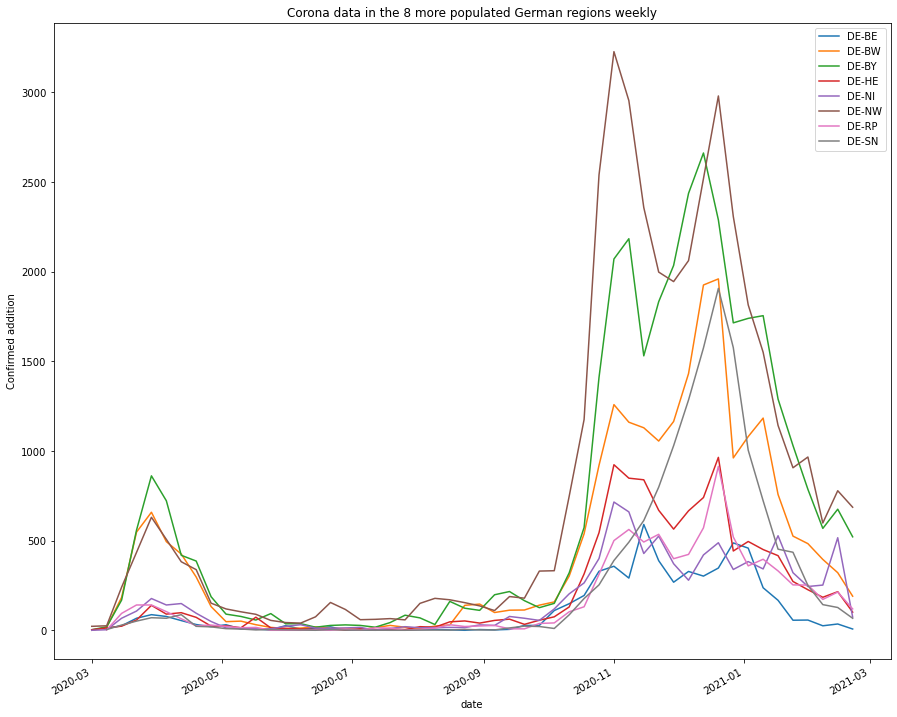

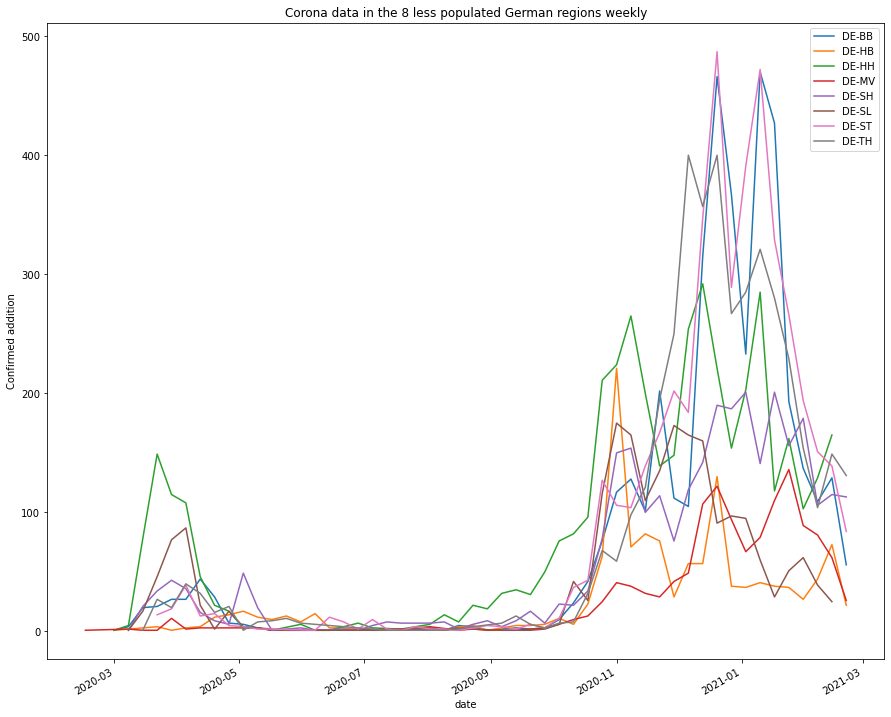

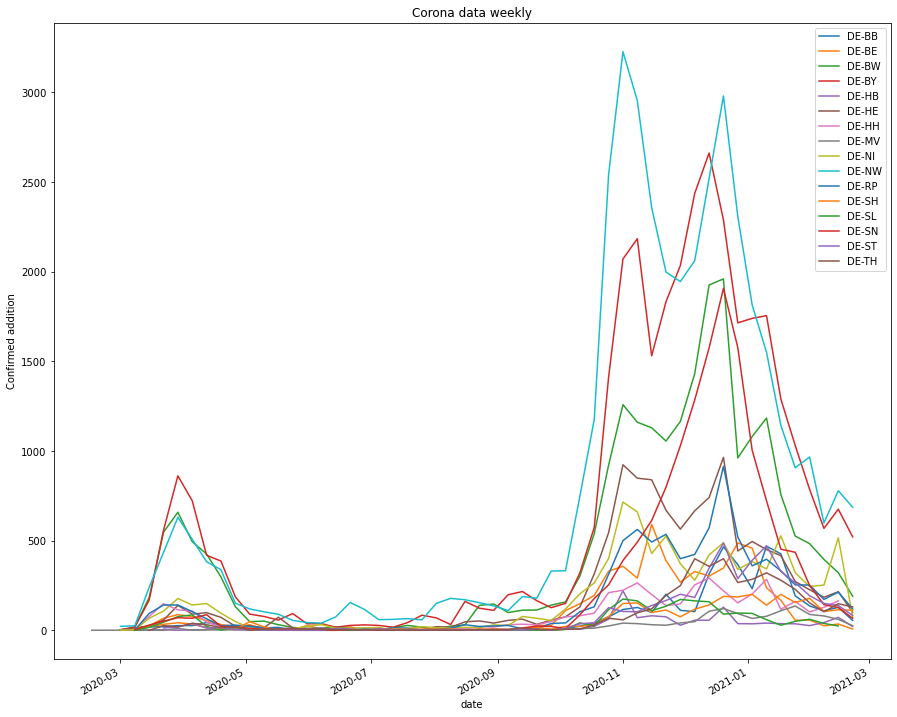

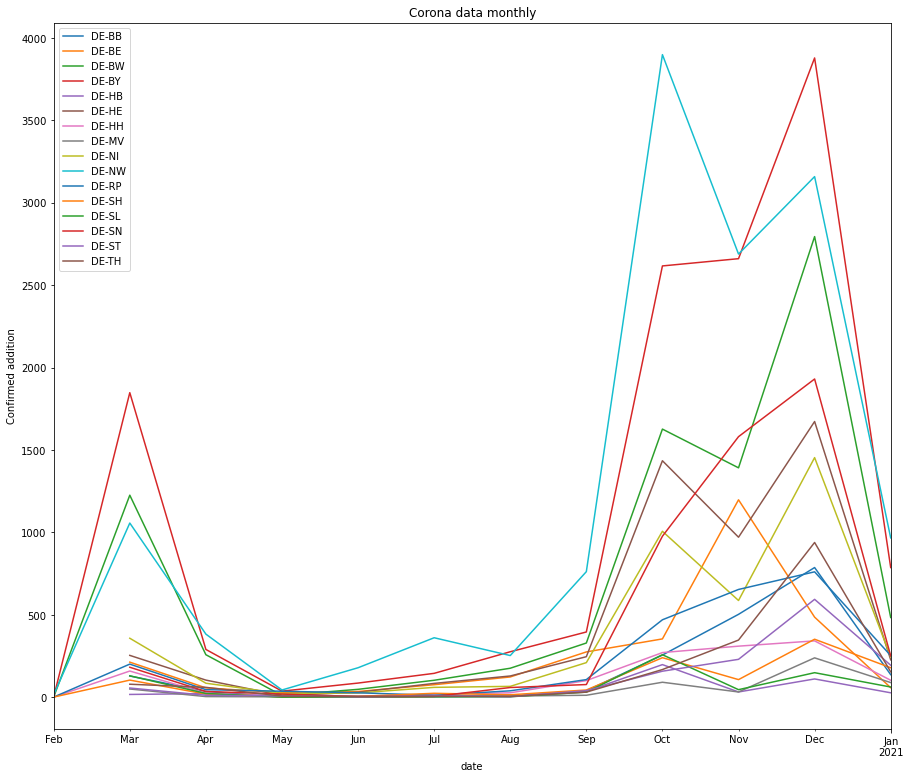

In [20]:
#Plotting corona data for 8 more populated German regions weekly
newmerged_df=cormerged_dfbyweek.loc[(cormerged_dfbyweek['region_code']=='DE-SN')|(cormerged_dfbyweek['region_code']=='DE-RP')|(cormerged_dfbyweek['region_code']=='DE-NW')|(cormerged_dfbyweek['region_code']=='DE-NI')|(cormerged_dfbyweek['region_code']=='DE-HE')|(cormerged_dfbyweek['region_code']=='DE-BY')|(cormerged_dfbyweek['region_code']=='DE-BW')|(cormerged_dfbyweek['region_code']=='DE-BE')]
newmerged_df.groupby('region_code')['confirmed_addition'].plot(x=newmerged_df.index,kind="line",legend=True, figsize=(15,13),title='Corona data in the 8 more populated German regions weekly',ylabel='Confirmed addition')
plt.show()
#Plotting corona data for 8 less populated German regions weekly
newmerged_df=cormerged_dfbyweek.loc[(cormerged_dfbyweek['region_code']=='DE-BB')|(cormerged_dfbyweek['region_code']=='DE-HB')|(cormerged_dfbyweek['region_code']=='DE-HH')|(cormerged_dfbyweek['region_code']=='DE-MV')|(cormerged_dfbyweek['region_code']=='DE-SL')|(cormerged_dfbyweek['region_code']=='DE-ST')|(cormerged_dfbyweek['region_code']=='DE-SH')|(cormerged_dfbyweek['region_code']=='DE-TH')]
newmerged_df.groupby('region_code')['confirmed_addition'].plot(x=newmerged_df.index,kind="line",legend=True, figsize=(15,13),title='Corona data in the 8 less populated German regions weekly',ylabel='Confirmed addition')
plt.show()
#Plotting corona data for all regions weekly
cormerged_dfbyweek.groupby('region_code')['confirmed_addition'].plot(x=cormerged_dfbyweek.index,kind="line",legend=True, figsize=(15,13),title='Corona data weekly',ylabel='Confirmed addition')
plt.show()
#Plotting corona data for all regions monthly
cormerged_dfbymonth.groupby('region_code')['confirmed_addition'].plot(x=cormerged_dfbymonth.index,kind="line",legend=True, figsize=(15,13),title='Corona data monthly',ylabel='Confirmed addition')
plt.show()


#### Plotting weather data
We already created dataframes with weather data grouped by date with average values for all the weater variables.
(RelativeHumiditySurface,Surfacepressure,TemperatureAboveGround,Totalprecipitation,UVIndex,WindSpeed)


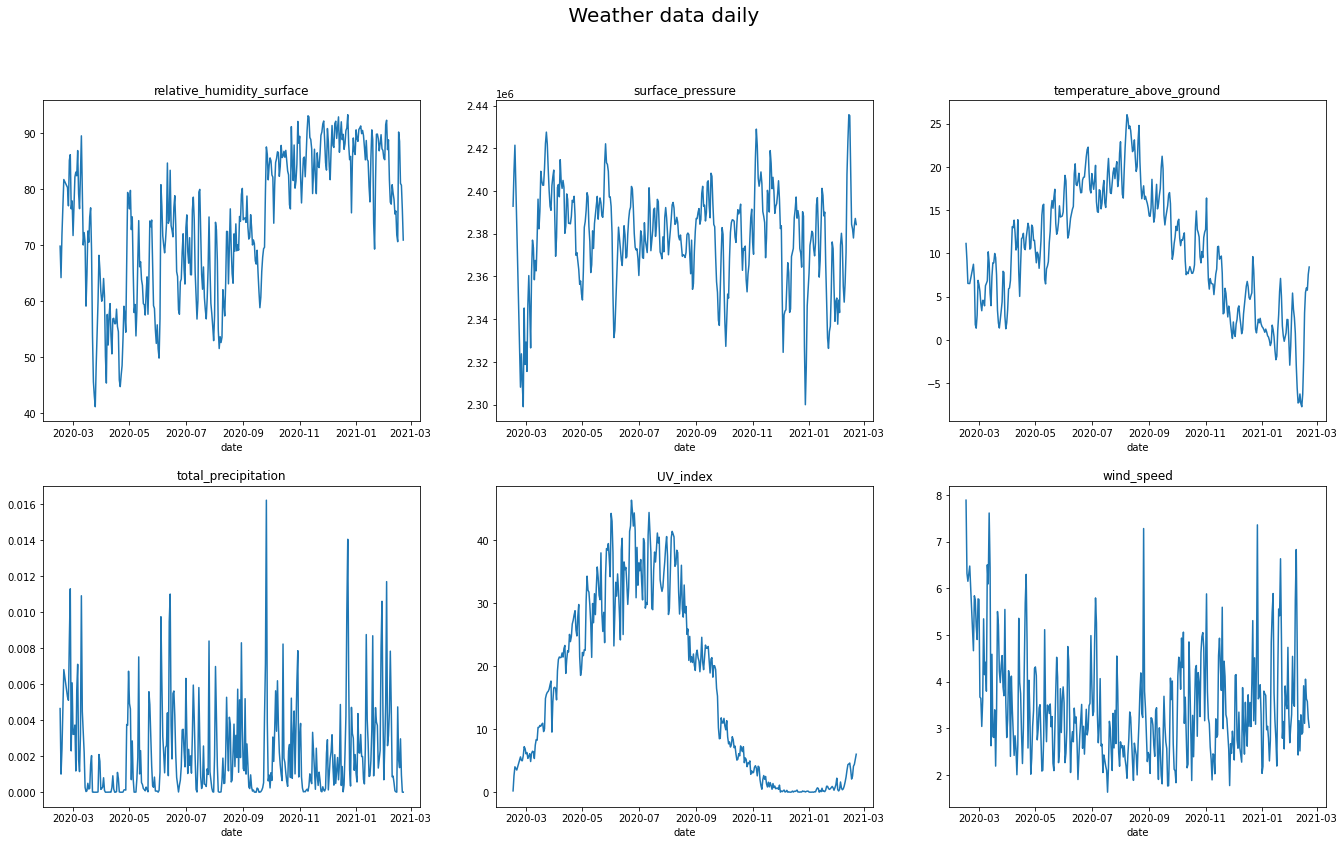

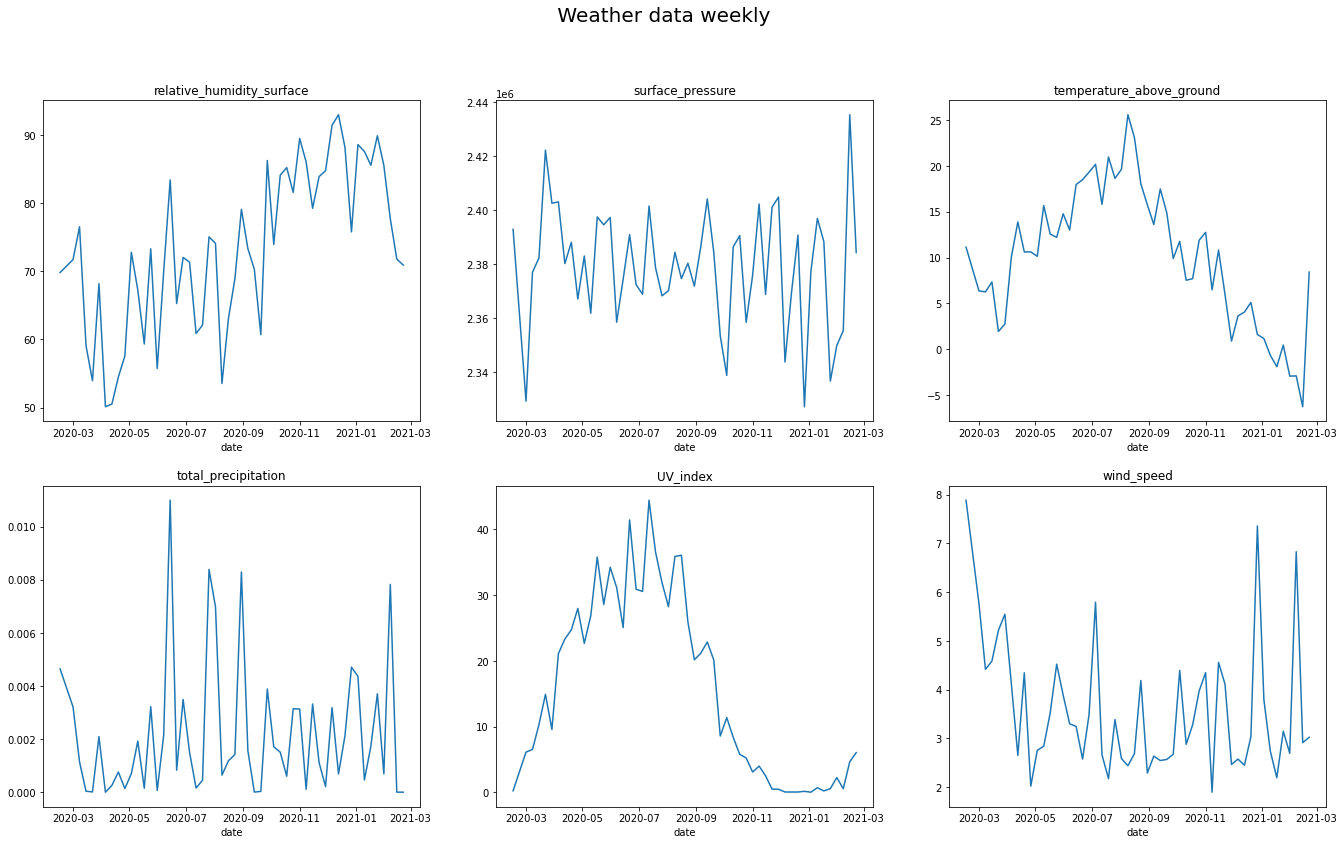

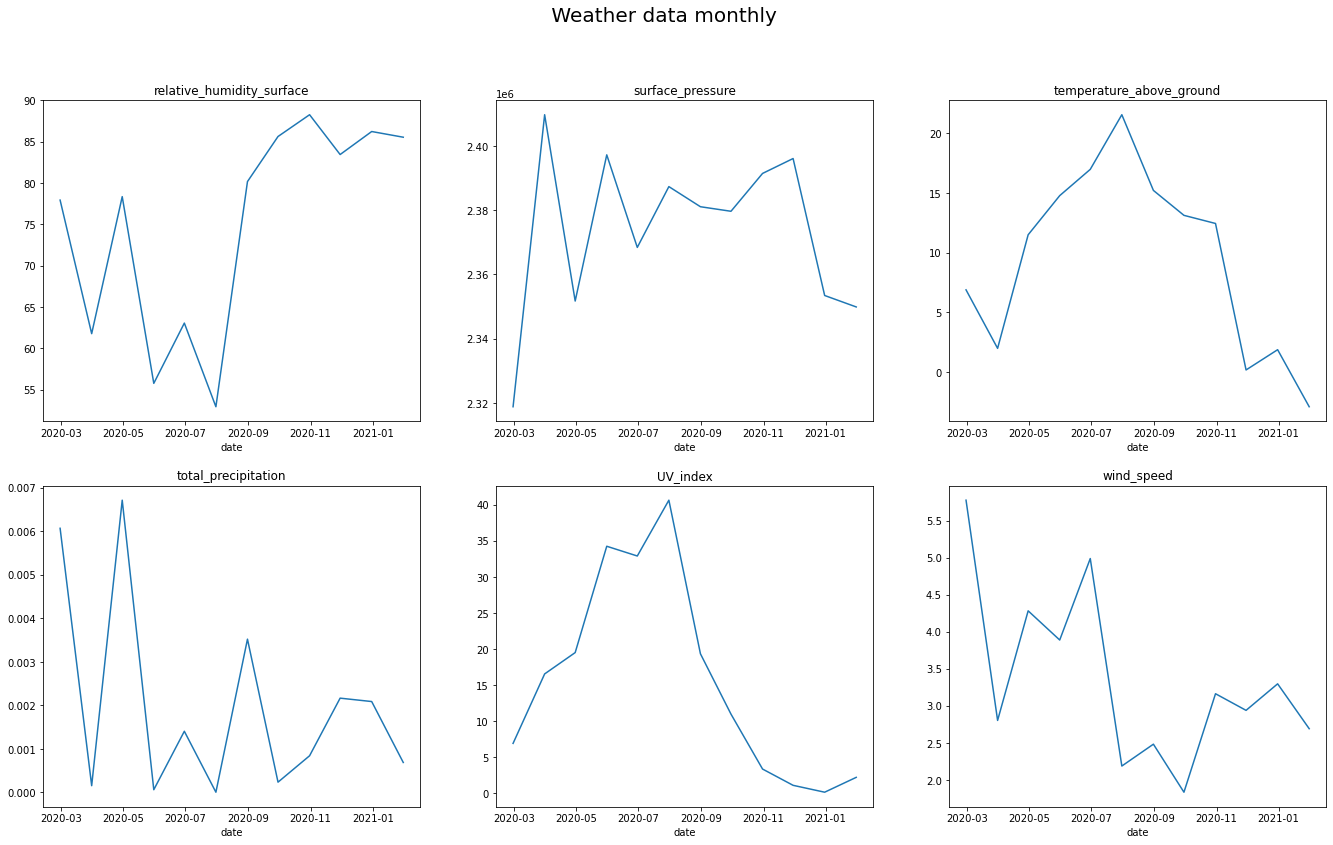

In [21]:
#we are plotting one subplot for each variable from the list:
weather=[['relative_humidity_surface','surface_pressure','temperature_above_ground'],['total_precipitation','UV_index','wind_speed']]
#We create figure for every time frequency  and then we plot 'date' column on X axis and weather data on Y axis
#plotting weather variables daily
fig, ax = plt.subplots(2,3,figsize=(23,13))
fig.suptitle(' Weather data daily ', fontsize=20)
for i in range(2):
    for j in range(3):
        ax[i][j].plot(merged_dfbydate['date'],merged_dfbydate[weather[i][j]])
        ax[i][j].set_title(weather[i][j])
        ax[i][j].set_xlabel('date')
#plotting weather variables weekly
fig1, ax1 = plt.subplots(2,3,figsize=(23,13))
fig1.suptitle(' Weather data weekly ', fontsize=20)
for i in range(2):
    for j in range(3):
        ax1[i][j].plot(merged_dfbyweek['date'],merged_dfbyweek[weather[i][j]])
        ax1[i][j].set_title(weather[i][j])
        ax1[i][j].set_xlabel('date')
#plotting weather variables monthly
fig2, ax2 = plt.subplots(2,3,figsize=(23,13),num='Weather data monthly')
fig2.suptitle(' Weather data monthly ', fontsize=20)
for i in range(2):
    for j in range(3):
        ax2[i][j].plot(merged_dfbymonth['date'],merged_dfbymonth[weather[i][j]])
        ax2[i][j].set_title(weather[i][j])
        ax2[i][j].set_xlabel('date')
     


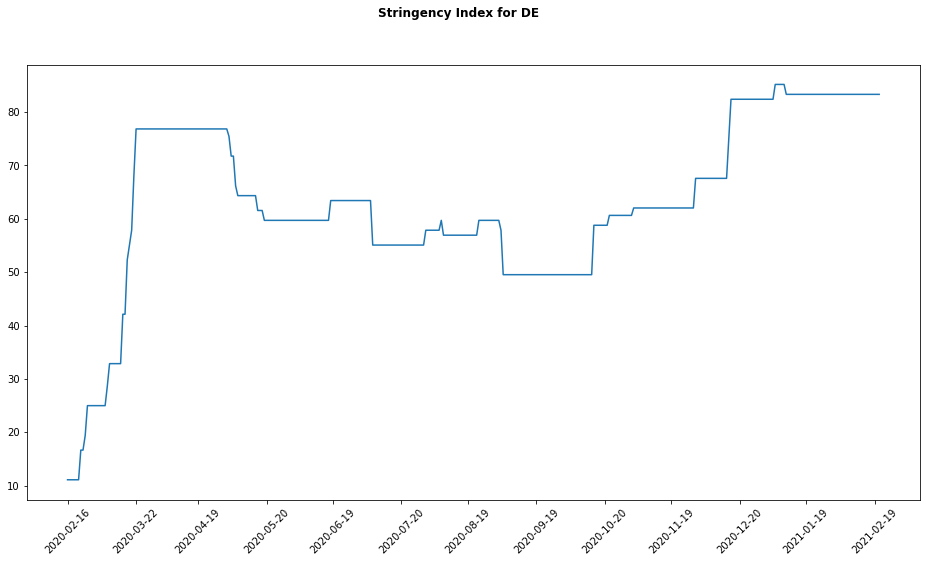

In [22]:
#Pulling data from our datafile from OWID and merging it to our data frame.\n",
owid = pd.read_csv("../Data/external/de_our_world_in_data_covid.csv")
owid = owid[owid["iso_code"] == "DEU"][['date', 'stringency_index']].dropna()
df = pd.read_csv("../Data/processed/de_corona_weather.csv")
df = df.merge(owid, on="date")
df.set_index('date', inplace=True)


#Visualizing the stringency index in comparison with confirmed cases.
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df.index, df["stringency_index"])
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=(1, 1)))
plt.xticks(rotation = 45)
fig.suptitle("Stringency Index for DE by month", fontweight = "bold");

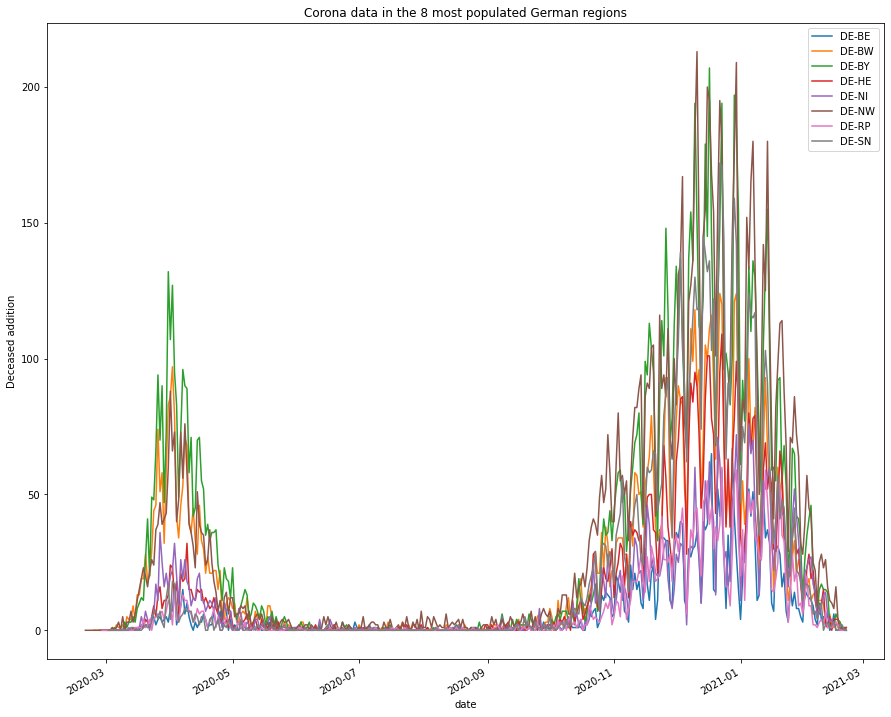

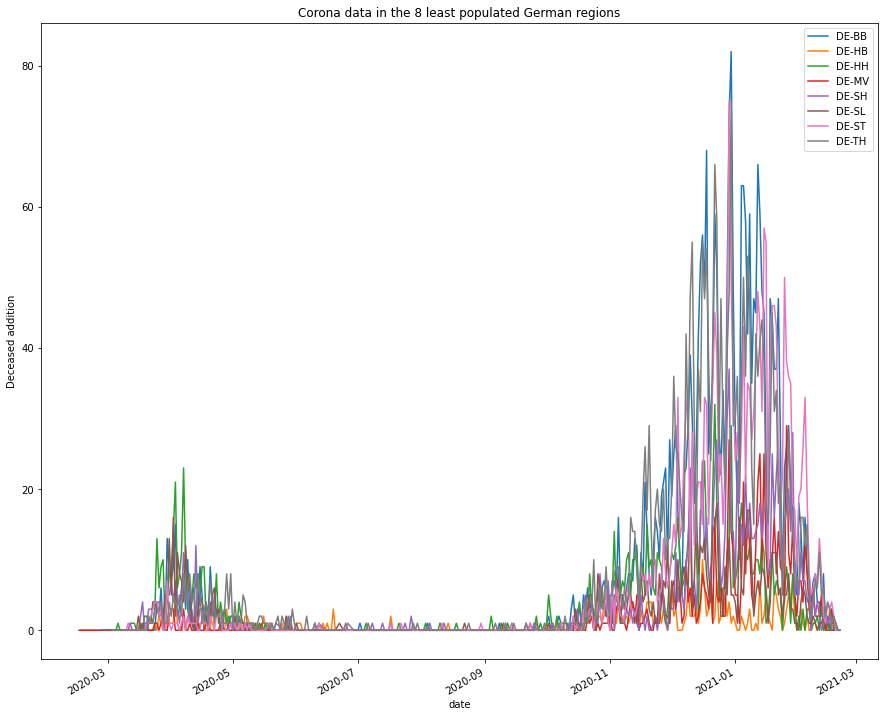

In [24]:
#merged_df.groupby('region_code')['deceased_addition'].plot(kind="line",legend=True, figsize=(15,13))
plt.show()
bigregions=pd.array(['DE-SN','DE-RP','DE-NW','DE-NI','DE-HE','DE-BY','DE-BW','DE-BE'])

merged_df
newmerged_df=merged_df.loc[(merged_df['region_code']=='DE-SN')|(merged_df['region_code']=='DE-RP')|
    (merged_df['region_code']=='DE-NW')|(merged_df['region_code']=='DE-NI')|(merged_df['region_code']=='DE-HE')|
    (merged_df['region_code']=='DE-BY')|(merged_df['region_code']=='DE-BW')|(merged_df['region_code']=='DE-BE')]

newmerged_df.groupby('region_code')['deceased_addition'].plot(kind="line",legend=True, figsize=(15,13),
    title='Corona data in the 8 most populated German regions',ylabel='Deceased addition')

plt.show()

newmerged_df=merged_df.loc[(merged_df['region_code']=='DE-BB')|(merged_df['region_code']=='DE-HB')|
    (merged_df['region_code']=='DE-HH')|(merged_df['region_code']=='DE-MV')|(merged_df['region_code']=='DE-SL')|
    (merged_df['region_code']=='DE-ST')|(merged_df['region_code']=='DE-SH')|(merged_df['region_code']=='DE-TH')]

newmerged_df.groupby('region_code')['deceased_addition'].plot(kind="line",legend=True, figsize=(15,13),
    title='Corona data in the 8 least populated German regions',ylabel='Deceased addition')

plt.show()


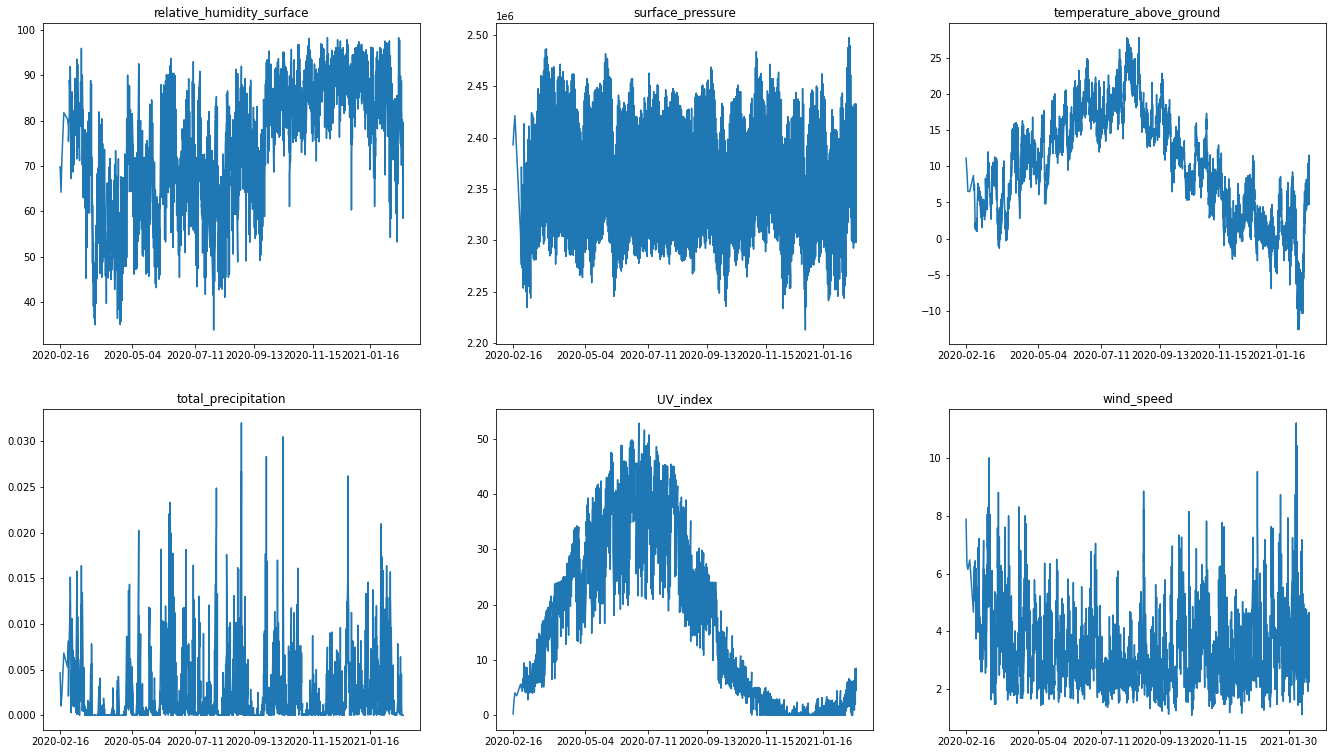

In [25]:
#weatherdata
fig, ax = plt.subplots(2,3,figsize=(23,13))

ax[0][0].plot(merged_df['relative_humidity_surface'])
ax[0, 0].set_title('relative_humidity_surface')
ax[0,0].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[0][1].plot(merged_df['surface_pressure'])
ax[0, 1].set_title('surface_pressure')
ax[0,1].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[0][2].plot(merged_df['temperature_above_ground'])
ax[0, 2].set_title('temperature_above_ground')
ax[0,2].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[1][0].plot(merged_df['total_precipitation'])
ax[1, 0].set_title('total_precipitation')
ax[1,0].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[1][1].plot(merged_df['UV_index'])
ax[1, 1].set_title('UV_index')
ax[1,1].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-16'])
ax[1][2].plot(merged_df['wind_speed'])
ax[1, 2].set_title('wind_speed')
ax[1,2].set_xticks(['2020-02-16','2020-05-04','2020-07-11','2020-09-13','2020-11-15','2021-01-30']);
#plt.xticks()


### Task 2: Associations

While researching whether there is a significant statistical association in Germany between weather data and infection rates, the most important variables that we took in consideration were:

> `R-squared` (%): analyzes how much the changes in the independent variable can explain the changes in the dependent variable
>
> `Adj. R-squared` (%): is R-squared, but modified for the number of variables
>
> `coef`: measures how change in one variable affect the independent variable; if negative, our variables will have an inverse relationship, meaning that if one increases the other decreases
>
> `t`: measurement of the precision with which the coefficient is measured
>
> `p > |t|`: p value, based on the t statistic, shows how likely is our coefficient measured through our model

In [20]:
# Variables from the collected weather data
Xs = ['relative_humidity_surface', 'solar_radiation', 'surface_pressure', 'temperature_above_ground', 
    'total_precipitation', 'UV_index', 'wind_speed']

# Adding a constant term to both our dataframe and the Xs list
merged_df = sm.add_constant(merged_df)
Xs.append('const')

# Performing the ordinary least squares regession to fit the regression line to our data
est = sm.OLS(merged_df['confirmed_addition'], merged_df[Xs], hasconst=True).fit()
est.summary()

/Users/viggogascou/anaconda3/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:     confirmed_addition   R-squared:                       0.263
Model:                            OLS   Adj. R-squared:                  0.262
Method:                 Least Squares   F-statistic:                     283.5
Date:                Thu, 03 Mar 2022   Prob (F-statistic):               0.00
Time:                        13:16:12   Log-Likelihood:                -44588.
No. Observations:                5580   AIC:                         8.919e+04
Df Residuals:                    5572   BIC:                         8.925e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
relative_humidity_surface     6.7314      1.468      4.585      0.000       3.854       9.609
solar_radiation            1.713e-05   3.89e-06      4.400      0.000     9.5e-06    2.48e-05
surface_pressure             -0.0041      0.000    -21.227      0.000      -0.005      -0.004
temperature_above_ground     -3.3505      2.232     -1.501      0.133      -7.726       1.025
total_precipitation       -1.814e+04   3506.060     -5.174      0.000    -2.5e+04   -1.13e+04
UV_index                    -26.0816      1.720    -15.166      0.000     -29.453     -22.710
wind_speed                  -52.4962      8.167     -6.428      0.000     -68.507     -36.485
const                      1.031e+04    478.312     21.565      0.000    9377.319    1.13e+04
==============================================================================
Omnibus:                     3905.013   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            62950.445
Skew:                           3.211   Prob(JB):                         0.00
Kurtosis:                      18.150   Cond. No.                     3.46e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.46e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

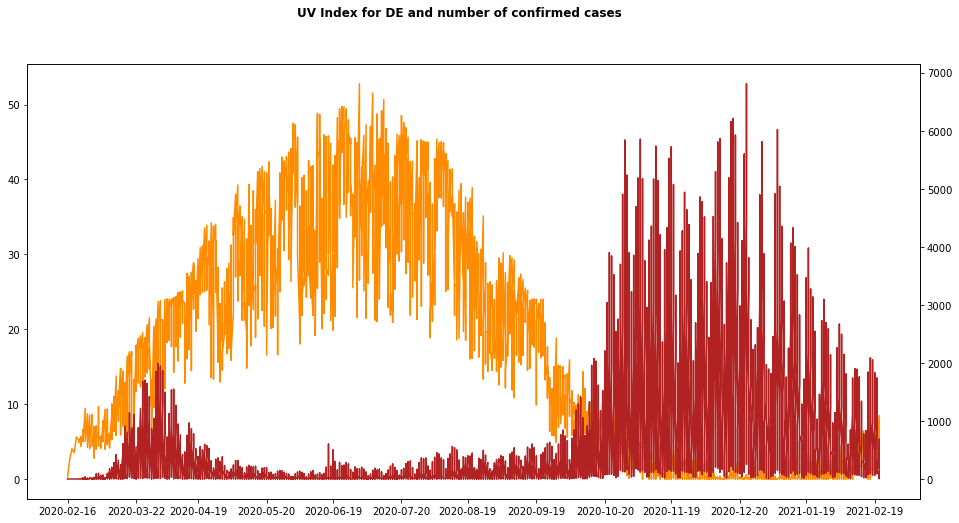

In [23]:
#Visualizing the UV index in comparisson with confirmed cases.
fig, ax = plt.subplots(figsize=(16, 8))
ax.plot(df.index, df["UV_index"], "darkorange")
ax2 = ax.twinx()
ax2.plot(df.index, df["confirmed_addition"], color ="firebrick")
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday=(1, 1)))
plt.xticks(rotation = 45)
fig.suptitle("UV Index for DE and number of confirmed cases", fontweight = "bold");

#### _Plotting weather variables with infection rates:_

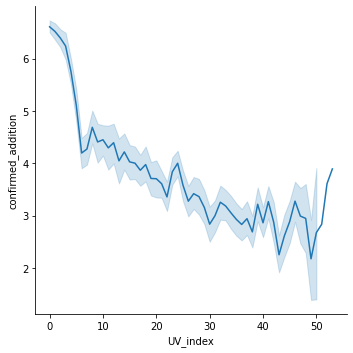

In [13]:
rel_df = merged_df.groupby(by = "UV_index" ) ["confirmed_addition"].mean().round().reset_index()
rel_df["UV_index"] = rel_df["UV_index"].round()
rel_df["confirmed_addition"] = np.log(rel_df["confirmed_addition"]+ 1)
sns.relplot(data=rel_df, x = "UV_index", y = "confirmed_addition", kind= "line");

#### _Association report:_

Based on the `0.263` value of `R-squared`, weather variables can be used to explain `26.3%` of cases. `Adj. R-squared` with the value of `0.262` is almost the same as `R-squared` since we are dealing with a small number of variables and thus `Ajd.  R-squared` can be ruled out as not relevant.

We have a `significance threshold` of `0.05` which is used to determine whether a variable has a significant association with our dependent value, `confirmed_addition`. If the variables have a `P-value` less than this (`0.05`) we cannot deny that there could be a correlation. Out of `8` independent variables, `temperature_above_ground` is the only one that can be excluded, since its `P-value` is `0.133`. 

We have chosen to focus on `relative_humidity_surface` and `UV_index` since they have the highest spikes in both negative and positive correlations with the `confirmed_additions`. The coefficients level for `relative_humidity_surface` shows that when it increases there is also a rise in the number of COVID-cases, whereas for spikes of `UV_index` values, there is a related decrease in COVID-cases.

### Task 3: Map Visualizations

In order to make it easier to create multiple maps we define a function. \
In this function you can specify what condition you want to visualize along with what color scale to use

In [28]:
#Creating a function for creating Folium maps with choropleths to make it easier 
# and more compact to create multiple maps for different variables.
def choropleth(data, condition, color):
    geo_json_path='../data/raw/shapefiles/de.geojson'
    f = folium.Figure(width=1000, height=600)
    m = folium.Map(location=[51.1657, 10.4515],zoom_start=6,crs='EPSG3857',
    zoom_control=False, scrollWheelZoom=False,dragging=False,tiles="cartodbpositron").add_to(f)

    folium.Choropleth(
        geo_data = geo_json_path,
        name = condition,
        data = data,
        columns = ["region_code", condition],
        key_on = "properties.iso_3166_2",
        fill_color = color,
        fill_opacity = 0.7,
        line_opacity = 0.2,
        legend_name = f"{condition.replace('-', ' ')}",
    ).add_to(m)
    
    return m

Making a map of the UV index across the different regions

In [29]:
choropleth(merged_df, "UV_index", "PuBu")

Making a map of the amount of COVID cases per region

In [30]:
choropleth(merged_df, "confirmed_addition", "OrRd")